In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
from joblib import dump, load
import matplotlib.pyplot as plt





In [2]:
from data_loader import load_fire_data
from feature_engineering import prepare_features

# Load raw data
df_raw = load_fire_data('../data/FPA_FOD_20170508.sqlite')



In [3]:
# Apply feature engineering
df_processed, scaler, label_encoders = prepare_features(df_raw)

# Inspect processed data
df_processed.head()


/Users/m.mughees/Desktop/Wildfire-Risk-Prediction/notebooks/feature_engineering.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DISCOVERY_HOUR'].fillna(df['DISCOVERY_HOUR'].median(), inplace=True)


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,Shape,DISCOVERY_HOUR,SEASON,CAUSE_SIMPLE,RISK_LEVEL
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,-1.513488,5.0,15,4,63,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,-0.389279,3,2,Low
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-1.477513,5.0,15,4,61,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,-2.078143,1,1,Low
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-1.497320,13.0,12,4,17,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,1.637358,1,0,Low
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-1.448135,5.0,15,4,3,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,0.624040,2,1,Low
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-1.449315,5.0,15,4,3,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,0.624040,2,1,Low


In [4]:
print("Scaler expects:", scaler.n_features_in_)


Scaler expects: 4


In [5]:
print(df_processed.columns.tolist())

['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'Shape', 'DISCOVERY_HOUR', 'SEASON', 'CAUSE_SIMPLE', 'RISK_LEVEL']


In [6]:

X = df_processed[[
    'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'DISCOVERY_HOUR',
    'STATE', 'OWNER_DESCR', 'SEASON', 'STAT_CAUSE_DESCR', 'CAUSE_SIMPLE'
]]

y = df_processed['RISK_LEVEL']

In [8]:
# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [7]:
# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

ValueError: could not convert string to float: 'Unknown'

In [19]:
# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class Weights:", class_weights)

Class Weights: {np.int64(0): np.float64(34.03954398015646), np.int64(1): np.float64(0.38736607031383163), np.int64(2): np.float64(2.5701325035205813)}


In [20]:
# Random Forest with class_weight
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weights
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.866010470734633

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.08      0.13      1747
           1       0.88      0.98      0.93    153517
           2       0.53      0.20      0.29     23138

    accuracy                           0.87    178402
   macro avg       0.62      0.42      0.45    178402
weighted avg       0.83      0.87      0.84    178402


Confusion Matrix:
 [[   139   1281    327]
 [    73 149791   3653]
 [   113  18457   4568]]


In [9]:
print(X_train.dtypes)
print(X_train.select_dtypes(include='object').head())

LATITUDE            float64
LONGITUDE           float64
DISCOVERY_DOY       float64
DISCOVERY_HOUR      float64
STATE                 int64
OWNER_DESCR           int64
SEASON                int64
STAT_CAUSE_DESCR      int64
CAUSE_SIMPLE         object
dtype: object
        CAUSE_SIMPLE
115592       Unknown
226729       Unknown
1646005      Unknown
699850       Unknown
1297740      Unknown


In [9]:
# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Original training set shape:", Counter(y_train))
print("Resampled training set shape:", Counter(y_resampled))

Original training set shape: Counter({np.int64(1): 1285036, np.int64(2): 210089, np.int64(0): 9247})
Resampled training set shape: Counter({np.int64(2): 1285036, np.int64(1): 1285036, np.int64(0): 1285036})


In [10]:
# Model training
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

In [11]:

# Predict on the original test set
y_pred_smote = rf_smote.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))


Accuracy: 0.7903045257423031

Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.25      0.14      2312
           1       0.91      0.85      0.88    321259
           2       0.35      0.46      0.40     52522

    accuracy                           0.79    376093
   macro avg       0.45      0.52      0.47    376093
weighted avg       0.82      0.79      0.81    376093


Confusion Matrix:
 [[   583    890    839]
 [  3983 272328  44948]
 [  1583  26622  24317]]


In [12]:
# Save the model
dump(rf_smote, '../models/rf_wildfire_model.joblib')

# Save the scaler
dump(scaler, '../models/scaler.joblib')

for col, encoder in label_encoders.items():
    dump(encoder, f'../models/{col.lower()}_encoder.joblib')

print("Model and scaler saved.")
print("Scaler expects:", scaler.n_features_in_)


Model and scaler saved.
Scaler expects: 4


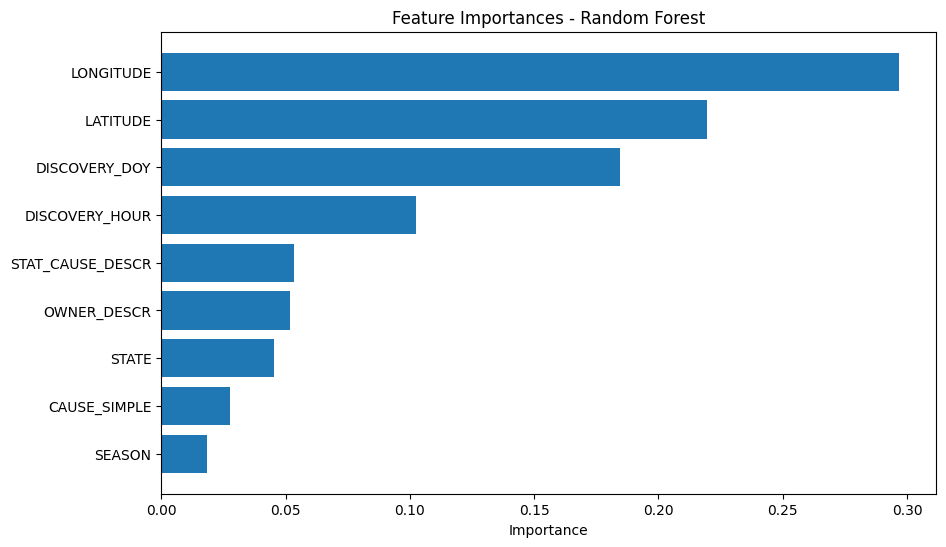

In [14]:
# Get feature importances
importances = rf_smote.feature_importances_
feature_names = X_train.columns  # Make sure X_train is a DataFrame

# Create a DataFrame for easier plotting
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# # Encode target labels
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
# )

# # Initialize XGBoost classifier
# xgb_model = XGBClassifier(
#     objective='multi:softmax',
#     num_class=len(label_encoder.classes_),
#     eval_metric='mlogloss',
#     use_label_encoder=False,
#     random_state=42
# )

# # Fit model
# xgb_model.fit(X_train, y_train)

# # Predict
# y_pred = xgb_model.predict(X_test)

# # Inverse transform predictions and true labels back to original classes
# y_test_labels = label_encoder.inverse_transform(y_test)
# y_pred_labels = label_encoder.inverse_transform(y_pred)

# # Now generate report with the original class names
# print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
# print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))


/Users/m.mughees/Desktop/Wildfire-Risk-Prediction/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [04:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8667223461620386

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.05      0.08      1747
           1       0.88      0.99      0.93    153517
           2       0.58      0.13      0.21     23138

    accuracy                           0.87    178402
   macro avg       0.64      0.39      0.41    178402
weighted avg       0.83      0.87      0.83    178402


Confusion Matrix:
 [[    80   1426    241]
 [    54 151524   1939]
 [    42  20075   3021]]


In [13]:
label_encoder = LabelEncoder()
label_encoder.fit(y)

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_resampled)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_resampled, y_resampled)

# Predictions on original test set
y_pred = xgb_model.predict(X_test)

# Inverse transform predictions and true labels if needed
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluation
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))

/Users/m.mughees/Desktop/Wildfire-Risk-Prediction/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [05:21:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7451990448537572

Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.52      0.13      1747
           1       0.93      0.78      0.85    153517
           2       0.33      0.54      0.41     23138

    accuracy                           0.75    178402
   macro avg       0.45      0.61      0.46    178402
weighted avg       0.85      0.75      0.78    178402


Confusion Matrix:
 [[   912    565    270]
 [  9043 119452  25022]
 [  2459   8098  12581]]
